<a href="https://colab.research.google.com/github/nainye/nlp_practice/blob/main/rnn_sltm_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evn

In [1]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [2]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# 입력 및 Vocab

In [4]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아 나는 오늘 우울해'
]

In [5]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [6]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)

train_inputs

array([[2, 3, 4, 5, 2, 3, 6]])

In [7]:
# embedding
embedding = tf.keras.layers.Embedding(len(word_to_id), 4)

In [8]:
# 단어벡터
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(1, 7, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292]]],
      dtype=float32)>

# RNN

## return sequence=False, return_state=False
(아무런 옵션을 주지 않은 경우)

In [9]:
# rnn
rnn_11 = tf.keras.layers.SimpleRNN(units=5)
output_11 = rnn_11(hidden)  # (bs, units)
print(output_11)

tf.Tensor([[ 0.0133051  -0.07108931  0.01356496  0.19825453 -0.03756267]], shape=(1, 5), dtype=float32)


In [10]:
# rnn weights
weights = rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit)
print(Wh.shape)  # (unit, unit)
print(b.shape)  # (unit,)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [11]:
# (return_sequences=True)
rnn_12 = tf.keras.layers.SimpleRNN(units=5, return_sequences=True)
output_12 = rnn_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[ 2.9929113e-02  4.1185715e-03 -7.3335785e-03 -2.7490623e-02
   -4.2592518e-02]
  [ 2.1723522e-02  3.4244298e-03 -8.8698808e-03  1.3401901e-02
   -2.1286123e-02]
  [ 4.8892803e-02 -1.5492372e-02  5.2009160e-03 -5.0389312e-02
   -6.7127943e-02]
  [ 5.3107738e-02  3.3684172e-02  4.7106575e-02  2.6926834e-02
   -1.6819069e-02]
  [ 6.6921949e-02 -6.2659383e-06  3.1169422e-02 -2.7292369e-02
    2.3001337e-02]
  [ 5.5012092e-02 -4.9766455e-02 -4.8280213e-02  2.3197087e-02
    1.8371815e-02]
  [ 1.5149739e-02 -9.3269765e-02  1.8400183e-02  7.5476407e-04
   -6.5119125e-02]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True
return_state만 True인 경우, 두 값이 같음

In [12]:
# (return_state=True)
rnn_13 = tf.keras.layers.SimpleRNN(units=5, return_state=True)
output_13, fw_h_13 = rnn_13(hidden)  # (bs, units), (bs, units)
print(output_13)
print(fw_h_13)

tf.Tensor([[-0.22489886  0.0802756   0.02204562 -0.07525434 -0.12735648]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.22489886  0.0802756   0.02204562 -0.07525434 -0.12735648]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [13]:
# (return_sequences=True, return_state=True)
rnn_14 = tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14 = rnn_14(hidden)  # (bs, seq, units), (bs, units)
print(output_14)
print(fw_h_14)

tf.Tensor(
[[[-0.00567131  0.00702238  0.0166551  -0.02649674 -0.00639815]
  [ 0.00745121  0.00397363 -0.03161482  0.00067732  0.03525217]
  [ 0.02503373  0.04381724 -0.01435504 -0.07607194 -0.03647323]
  [ 0.03158387 -0.03594297 -0.03295876  0.09170678  0.00911083]
  [-0.06396969  0.06692141  0.02803503 -0.07891872 -0.05069153]
  [ 0.03279418 -0.04417153 -0.09341431  0.0333666   0.09773416]
  [ 0.01325146  0.01543665  0.01574938 -0.08289386 -0.10723303]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[ 0.01325146  0.01543665  0.01574938 -0.08289386 -0.10723303]], shape=(1, 5), dtype=float32)


## init hidden state

In [14]:
rnn_11(hidden, initial_state=[fw_h_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.06465904, -0.25594386, -0.12518847,  0.13231519, -0.02561215]],
      dtype=float32)>

In [15]:
rnn_12(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[ 0.08970518,  0.12074085,  0.02214284, -0.00741253,
         -0.06301705],
        [ 0.06890634,  0.02803107,  0.03387965, -0.06119582,
          0.07141123],
        [ 0.13040169, -0.04140752, -0.09347053, -0.06496175,
         -0.03006374],
        [ 0.11627129, -0.0390062 ,  0.06014571, -0.02257581,
         -0.09820992],
        [ 0.14631155,  0.0332644 ,  0.08039215,  0.05096842,
         -0.0258085 ],
        [ 0.08789143, -0.06898136,  0.05173643,  0.0284674 ,
          0.1006607 ],
        [ 0.04806692, -0.15309522, -0.04242581,  0.05481387,
          0.01750817]]], dtype=float32)>

In [16]:
rnn_13(hidden, initial_state=[fw_h_13])  # (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.16090795, -0.01084654,  0.00649465,  0.03989044,  0.08458714]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.16090795, -0.01084654,  0.00649465,  0.03989044,  0.08458714]],
       dtype=float32)>]

In [17]:
rnn_14(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.04023583, -0.04856527, -0.00745723,  0.08569601,
           0.03263333],
         [-0.03993218,  0.04022601, -0.0133417 , -0.1201784 ,
           0.01704529],
         [ 0.08773063, -0.04925723, -0.03939974, -0.01440458,
           0.00531509],
         [-0.01835137,  0.00441733,  0.04440122,  0.04724793,
          -0.07235702],
         [-0.06754464,  0.03039353,  0.0077003 , -0.02238409,
           0.0663793 ],
         [ 0.07404423, -0.00928033, -0.04943877, -0.06849191,
           0.03991261],
         [ 0.03545617, -0.01660541,  0.01871964,  0.04337611,
          -0.07521319]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.03545617, -0.01660541,  0.01871964,  0.04337611, -0.07521319]],
       dtype=float32)>]

# LSTM

## return sequence=False, return_state=False

In [18]:
# lstm
lstm_11 = tf.keras.layers.LSTM(units=5)
output_11 = lstm_11(hidden)  # (bs, units)
print(output_11)

tf.Tensor([[ 0.01252828 -0.01186483 -0.01100005  0.00128962  0.00689079]], shape=(1, 5), dtype=float32)


In [19]:
# lstm weights
weights = lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 4) (Wxf, Wxi, Wxc, Wxo)
print(Wh.shape)  # (unit, unit * 4) (Whf, Whi, Whc, Who)
print(b.shape)  # (unit * 4) (bf, bi, bc, bo)

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [20]:
# (return_sequences=True)
lstm_12 = tf.keras.layers.LSTM(units=5, return_sequences=True)
output_12 = lstm_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[-0.00544438 -0.00505095  0.00146407 -0.00019775 -0.00408297]
  [ 0.00092337  0.00106309 -0.00256752  0.00214575 -0.00409309]
  [-0.00466804 -0.00234009 -0.00467811  0.00283395 -0.01177095]
  [-0.00136526  0.00112071 -0.00880491  0.00172207 -0.00966275]
  [-0.00722189 -0.00401253 -0.00514568  0.00093245 -0.01217541]
  [-0.00101653  0.00202121 -0.00762216  0.00274471 -0.01070324]
  [ 0.00060078  0.00327611 -0.0104871   0.00319098 -0.00986872]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [21]:
# (return_state=True)
lstm_13 = tf.keras.layers.LSTM(units=5, return_state=True)
output_13, fw_h_13, fw_c_13 = lstm_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)

tf.Tensor(
[[ 7.6129837e-03 -1.5287815e-02  7.3035844e-03  4.7374528e-05
   1.1121367e-02]], shape=(1, 5), dtype=float32)
tf.Tensor(
[[ 7.6129837e-03 -1.5287815e-02  7.3035844e-03  4.7374528e-05
   1.1121367e-02]], shape=(1, 5), dtype=float32)
tf.Tensor(
[[ 1.5119700e-02 -3.0797761e-02  1.4539103e-02  9.5068710e-05
   2.2492610e-02]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [22]:
# (return_sequences=True, return_state=True)
lstm_14 = tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14, fw_c_14 = lstm_14(hidden)  # (bs, seq, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)

tf.Tensor(
[[[ 0.00040525 -0.00275002  0.00038114 -0.00120663  0.00231446]
  [-0.00520107 -0.00223845 -0.00043894 -0.0053069  -0.00388033]
  [-0.00688379 -0.00716671 -0.00024295 -0.00974881 -0.00305707]
  [-0.00176606 -0.0059406   0.00495924 -0.00458891 -0.00075247]
  [-0.00092784 -0.00677031  0.00413757 -0.00491618  0.00158901]
  [-0.00619131 -0.00487417  0.00241962 -0.00824052 -0.00451456]
  [-0.00361855 -0.00470538  0.00690781 -0.00543056 -0.0025354 ]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[-0.00361855 -0.00470538  0.00690781 -0.00543056 -0.0025354 ]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.00723412 -0.0093214   0.01380899 -0.01084146 -0.00508808]], shape=(1, 5), dtype=float32)


## init hidden state

In [23]:
lstm_11(hidden, initial_state=[fw_h_13, fw_c_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.01215497, -0.01394066, -0.01243898,  0.00035355,  0.00925506]],
      dtype=float32)>

In [24]:
lstm_12(hidden, initial_state=[fw_h_14, fw_c_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[-7.3097218e-03, -8.6579267e-03,  6.5108277e-03, -4.6995520e-03,
         -6.1655948e-03],
        [ 2.5162593e-04, -1.8132351e-03,  1.2117121e-03, -1.3395882e-03,
         -5.7245716e-03],
        [-4.5920075e-03, -4.5240764e-03, -1.8206030e-03,  4.4292374e-05,
         -1.3040293e-02],
        [-8.1744191e-04, -5.4931070e-04, -6.6617574e-03, -3.8644686e-04,
         -1.0613153e-02],
        [-6.4202966e-03, -5.2729584e-03, -3.5087359e-03, -6.8675214e-04,
         -1.2861537e-02],
        [-8.9272165e-05,  1.0454296e-03, -6.3446397e-03,  1.5852144e-03,
         -1.1164520e-02],
        [ 1.5599113e-03,  2.5538309e-03, -9.4951764e-03,  2.3441282e-03,
         -1.0163450e-02]]], dtype=float32)>

In [25]:
lstm_13(hidden, initial_state=[fw_h_13, fw_c_13])  # (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01113445, -0.0181876 ,  0.01266127, -0.00279448,  0.01636327]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01113445, -0.0181876 ,  0.01266127, -0.00279448,  0.01636327]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.02208105, -0.03670878,  0.02523495, -0.0056196 ,  0.03310997]],
       dtype=float32)>]

In [26]:
lstm_14(hidden, initial_state=[fw_h_14, fw_c_14])  # (bs, n_seq, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.00241018, -0.00558355,  0.00569973, -0.0054552 ,
           0.00055526],
         [-0.00738834, -0.00379501,  0.00365711, -0.00856859,
          -0.00504782],
         [-0.0085752 , -0.00787436,  0.00294753, -0.01219721,
          -0.00383559],
         [-0.00311176, -0.00611526,  0.00749481, -0.00639922,
          -0.00124679],
         [-0.00200747, -0.00661883,  0.00610426, -0.00623128,
           0.00128764],
         [-0.00705873, -0.00454286,  0.00394774, -0.00918079,
          -0.00467455],
         [-0.00432382, -0.00428938,  0.00812357, -0.00609291,
          -0.00260176]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00432382, -0.00428938,  0.00812357, -0.00609291, -0.00260176]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00864326, -0.00849324,  0.016246  , -0.01216442, -0.00522   ]],
       dtype=float32)>]

# GRU

## return sequence=False, return_state=False

In [27]:
# bi GRU
gru_11 = tf.keras.layers.GRU(units=5)
output_11 = gru_11(hidden)  # (bs, units)
print(output_11)

tf.Tensor([[-0.00128841  0.01591058 -0.01686392 -0.00689237 -0.01078903]], shape=(1, 5), dtype=float32)


In [28]:
# bi GRU weights
weights = gru_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 3) (Wxr, Wxz, Wxg)
print(Wh.shape)  # (unit, unit * 3) (Whr, Whz, Whg)
print(b.shape)  # (2, unit * 3) (bxr, bxz, bxg),(bhr, bhz, bhg)

(4, 15)
(5, 15)
(2, 15)


## return sequence=True, return_state=False

In [29]:
# (return_sequences=True)
gru_12 = tf.keras.layers.GRU(units=5, return_sequences=True)
output_12 = gru_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[-0.00724988 -0.01204025 -0.00660731 -0.00241936  0.01091108]
  [-0.00690028 -0.00760665  0.00473171  0.02366268  0.02218487]
  [-0.01982779 -0.02418694 -0.000265    0.03126299  0.04256844]
  [-0.00805993 -0.00707422  0.00594501  0.02301816  0.02065855]
  [-0.0146784  -0.0149042  -0.00365479  0.01337637  0.02291579]
  [-0.01298529 -0.00852203  0.00638297  0.03420675  0.02937598]
  [-0.01063064 -0.00421955  0.01115373  0.0308162   0.02547237]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [30]:
# (return_state=True)
gru_13 = tf.keras.layers.GRU(units=5, return_state=True)
output_13, fw_h_13 = gru_13(hidden)  # (bs, units), (bs, units)
print(output_13)
print(fw_h_13)

tf.Tensor([[-0.0019341   0.01071739  0.00788937  0.01066312 -0.00221146]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.0019341   0.01071739  0.00788937  0.01066312 -0.00221146]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [31]:
# (return_sequences=True, return_state=True)
gru_14 = tf.keras.layers.GRU(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14 = gru_14(hidden)  # (bs, seq, units * 2), (bs, units)
print(output_14)
print(fw_h_14)

tf.Tensor(
[[[-0.00381347  0.00607597  0.00153289  0.00026855  0.01145666]
  [-0.00331714  0.01010486 -0.01224199 -0.01133284  0.00853806]
  [-0.00093711  0.01803945 -0.0145158  -0.01409486  0.02851611]
  [ 0.00880802  0.01154291 -0.0096231  -0.00740737  0.012196  ]
  [ 0.00363141  0.01305108 -0.00426213 -0.00214698  0.01840561]
  [ 0.00235771  0.01434101 -0.01598028 -0.01207952  0.01253426]
  [ 0.00402145  0.01470503 -0.0129416  -0.01024149  0.00994625]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[ 0.00402145  0.01470503 -0.0129416  -0.01024149  0.00994625]], shape=(1, 5), dtype=float32)


## init hidden state

In [32]:
gru_11(hidden, initial_state=[fw_h_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.00140842,  0.01592344, -0.01623747, -0.00670336, -0.01101907]],
      dtype=float32)>

In [33]:
gru_12(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[-0.00300019, -0.00323922, -0.01454308, -0.00958822,
          0.01849951],
        [-0.00319965, -0.00230684, -0.00040348,  0.0188137 ,
          0.02772161],
        [-0.01684529, -0.02090497, -0.00366238,  0.02805248,
          0.04653085],
        [-0.00582952, -0.00502904,  0.00368652,  0.0209058 ,
          0.02341765],
        [-0.01303946, -0.01359165, -0.00516605,  0.01199155,
          0.02483771],
        [-0.01180617, -0.00767625,  0.00535123,  0.03328608,
          0.03071455],
        [-0.00979845, -0.00366684,  0.01045386,  0.03020769,
          0.02639962]]], dtype=float32)>

In [34]:
gru_13(hidden, initial_state=[fw_h_13])  # (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>]

In [35]:
gru_14(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[ 0.00120912,  0.01436689, -0.00526015, -0.00245608,
           0.01752719],
         [ 0.00106435,  0.0148916 , -0.01622299, -0.01184704,
           0.01214018],
         [ 0.00249824,  0.02077618, -0.01704834, -0.01405097,
           0.03059548],
         [ 0.01132524,  0.01315177, -0.01130751, -0.0072835 ,
           0.01345716],
         [ 0.00543236,  0.0139883 , -0.00539421, -0.00206096,
           0.01916937],
         [ 0.00361664,  0.0148993 , -0.01673315, -0.01203724,
           0.01301165],
         [ 0.00488993,  0.01504152, -0.01344696, -0.01023171,
           0.01024941]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00488993,  0.01504152, -0.01344696, -0.01023171,  0.01024941]],
       dtype=float32)>]

# Bidirectional RNN

## return sequence=False, return_state=False

In [36]:
# bi rnn
bi_rnn_11 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5))
output_11 = bi_rnn_11(hidden)  # (bs, units * 2)
print(output_11)

tf.Tensor(
[[ 0.00189245 -0.08352485 -0.07952984 -0.02134595  0.01254619 -0.10349478
  -0.0285648  -0.15433243  0.04896942  0.06491221]], shape=(1, 10), dtype=float32)


In [37]:
# bi rnn weights
weights = bi_rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit)
print(Wh.shape)  # (unit, unit)
print(b.shape)  # (unit,)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [38]:
# (return_sequences=True)
bi_rnn_12 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True))
output_12 = bi_rnn_12(hidden)  # (bs, seq, units* 2)
print(output_12)

tf.Tensor(
[[[ 0.02063903  0.03965816  0.03919788  0.02908318 -0.02135444
    0.03373569  0.14357285  0.02265848 -0.01834988  0.01760596]
  [-0.06732997  0.0119262   0.01037599  0.03202324 -0.04788924
   -0.02202282 -0.12320485  0.00310691  0.03954257  0.02772265]
  [-0.0069248   0.09928044  0.00049278  0.0842956  -0.02588288
    0.02357069  0.03469789  0.06235293 -0.08903261  0.01622928]
  [-0.10489257  0.04832265  0.01487477  0.05294417  0.00262039
   -0.02221388 -0.06631253 -0.00934883  0.01024336  0.03339538]
  [-0.02521386  0.11432075  0.0165207   0.04469954  0.06719342
    0.04058785  0.02231554 -0.00393319 -0.01607522  0.03056315]
  [-0.08703329  0.0155736   0.07161146  0.08565228  0.04799198
    0.02592861 -0.0405432  -0.03698469 -0.03118086  0.01623693]
  [-0.0069922   0.11693995  0.02447139  0.02125133  0.06086859
   -0.0062323  -0.04051992 -0.00674628 -0.02538863 -0.00846069]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [39]:
# (return_state=True)
bi_rnn_13 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_state=True))
output_13, fw_h_13, bw_h_13 = bi_rnn_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(bw_h_13)

tf.Tensor(
[[ 0.10142464  0.04384788  0.03959855  0.09941956  0.05877534  0.19237266
  -0.0812621   0.04585575  0.21233375 -0.06199192]], shape=(1, 10), dtype=float32)
tf.Tensor([[0.10142464 0.04384788 0.03959855 0.09941956 0.05877534]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.19237266 -0.0812621   0.04585575  0.21233375 -0.06199192]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [40]:
# (return_sequences=True, return_state=True)
bi_rnn_14 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, bw_h_14 = bi_rnn_14(hidden)  # (bs, seq, units * 2), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(bw_h_14)

tf.Tensor(
[[[-0.01223004 -0.03604717 -0.01213866  0.00832459 -0.00985193
   -0.06842467  0.03804656 -0.21594404 -0.07498586  0.12322078]
  [-0.01207433 -0.02585809  0.01065563  0.01178059 -0.05265585
    0.07812028 -0.15373422 -0.00190183 -0.13922727  0.13310388]
  [-0.0369997  -0.07803842  0.04209687  0.04328766 -0.0377161
    0.07696803  0.08312834 -0.0637846  -0.02303878  0.17275529]
  [-0.03149062 -0.00641296  0.09045608  0.04872282 -0.02032937
   -0.06239615 -0.07913799  0.00644676 -0.02948124  0.07311696]
  [-0.00251457  0.00482455  0.03361512  0.09806919 -0.01537912
    0.00374245  0.03065289 -0.0893319  -0.05894311  0.0406061 ]
  [ 0.06832523  0.01860224  0.02926934  0.06120522 -0.07875361
    0.03820577 -0.03235298  0.02452953 -0.05579672  0.06007537]
  [ 0.07677121  0.03446358  0.09452506 -0.03025864  0.00149059
    0.02181129  0.02294274 -0.00379264 -0.01796763  0.03280125]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[ 0.07677121  0.03446358  0.09452506 -0.03025864  0.00

## return sequence=True, return_state=True, dual cell

In [41]:
fw_cell = tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True)
bw_cell = tf.keras.layers.SimpleRNN(units=5, go_backwards=True, return_sequences=True, return_state=True)
bi_rnn_15 = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
output_15, fw_h_15, bw_h_15 = bi_rnn_15(hidden)  # (bs, seq, units * 2), (bs, units), (bs, units)
print(output_15)
print(fw_h_15)
print(bw_h_15)

tf.Tensor(
[[[-0.02504721 -0.00409831 -0.00945844 -0.01428669 -0.0128261
    0.04066376 -0.04710311  0.07474758  0.13280307  0.025421  ]
  [-0.03257211 -0.02711307 -0.00310748  0.01098206 -0.00213756
    0.11689561 -0.13379344 -0.01107384 -0.00803275  0.0499415 ]
  [-0.07570328 -0.04383892 -0.03580526 -0.0051623  -0.02244059
   -0.02333836 -0.06808434 -0.06293817  0.01065937  0.09979907]
  [-0.06539232 -0.02327299  0.02191263  0.0727077   0.03826915
    0.00256722 -0.00392566  0.01833091  0.00498594  0.05730335]
  [-0.08141567 -0.04813    -0.06701369 -0.04549714  0.03823739
    0.01702488 -0.00234942  0.01800713  0.03467437  0.04774953]
  [-0.12271711 -0.06269672  0.00942702  0.02784525 -0.04749537
    0.06121849 -0.02194346 -0.00813043 -0.02851701  0.04329199]
  [-0.08817548 -0.07766607  0.00235618  0.05484834  0.10091185
    0.01337676  0.01245785 -0.01996882 -0.01247303  0.021705  ]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[-0.08817548 -0.07766607  0.00235618  0.05484834  0.10

## init hidden state

In [42]:
bi_rnn_11(hidden, initial_state=[fw_h_13, bw_h_13])  # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.03366552,  0.02708556, -0.08833596,  0.02204747,  0.11622974,
        -0.09725527, -0.23567978, -0.14445539,  0.18366566, -0.04445881]],
      dtype=float32)>

In [43]:
bi_rnn_12(hidden, initial_state=[fw_h_14, bw_h_13])  # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-0.00958689,  0.03306837,  0.121411  , -0.05310354,
         -0.069801  , -0.02629121, -0.11530273,  0.01831289,
          0.10370483,  0.00090374],
        [-0.08903914, -0.00823849, -0.0190354 , -0.08953566,
         -0.03271431,  0.05697922,  0.07164459,  0.06341173,
         -0.15536907, -0.00161413],
        [ 0.02232581, -0.00883719, -0.02639926,  0.04660335,
          0.01856824, -0.10517551, -0.06117185, -0.04557626,
          0.13275433,  0.04639041],
        [ 0.01353182,  0.0045039 ,  0.00479941,  0.05030999,
         -0.02010383,  0.12938042, -0.06425252,  0.154506  ,
         -0.17298795, -0.03522091],
        [ 0.00532184,  0.08084926,  0.03913519,  0.04759575,
         -0.05087128, -0.15462299,  0.11073715, -0.15637334,
          0.09666155,  0.11731722],
        [-0.11827581,  0.02918995,  0.00035898,  0.04068657,
         -0.04247621,  0.23023193, -0.17038245,  0.12133423,
         -0.0254918 , -0.06646967],


In [44]:
bi_rnn_13(hidden, initial_state=[fw_h_13, bw_h_13])  # (bs, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[ 0.21820247,  0.12051318,  0.03422751,  0.10649262,  0.11619177,
          0.31769818, -0.1452783 ,  0.04461537,  0.30978465,  0.12155465]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[0.21820247, 0.12051318, 0.03422751, 0.10649262, 0.11619177]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.31769818, -0.1452783 ,  0.04461537,  0.30978465,  0.12155465]],
       dtype=float32)>]

In [45]:
bi_rnn_14(hidden, initial_state=[fw_h_14, bw_h_14])  # (bs, n_seq, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[-0.01605418,  0.08521216,  0.0078772 , -0.0052132 ,
           0.02986129, -0.08073806, -0.1815616 , -0.25961483,
          -0.1164571 ,  0.19696285],
         [ 0.04976505,  0.01947389, -0.06751592,  0.02501593,
           0.01579403,  0.17407653, -0.08744309, -0.17113188,
          -0.17401794,  0.25746423],
         [ 0.01264184, -0.07194784, -0.03912848, -0.03732142,
          -0.07277703,  0.09552309, -0.07634459, -0.01732119,
           0.0321065 ,  0.3469225 ],
         [-0.05013778, -0.04536489,  0.09190015, -0.06441393,
           0.02577551, -0.14590359, -0.03704872, -0.19435067,
          -0.02591169,  0.20409103],
         [-0.11520644,  0.00189497, -0.0134646 ,  0.07705233,
           0.02070227,  0.04140927, -0.18265297, -0.11942258,
          -0.15420507,  0.14669563],
         [ 0.038363  , -0.0723078 , -0.03828006,  0.11328387,
          -0.0663591 ,  0.12099791,  0.06455711, -0.10884315,
          -0.07171

In [46]:
bi_rnn_15(hidden, initial_state=[fw_h_15, bw_h_15])  # (bs, n_seq, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[-0.13737047, -0.09679037, -0.05934018, -0.06886436,
          -0.00523294,  0.0727886 , -0.09048022,  0.08307764,
           0.12412102, -0.12453701],
         [-0.14075463, -0.11724226,  0.04581405,  0.07459354,
          -0.01426174,  0.06995551, -0.21205617, -0.1117911 ,
          -0.01708969, -0.03501226],
         [-0.12785263, -0.16240634, -0.06420331,  0.00073943,
           0.0690548 , -0.16556312, -0.11455913, -0.06187297,
           0.04945378,  0.05067914],
         [-0.15724663, -0.13813078,  0.00650161,  0.04300582,
          -0.01467413, -0.02506764, -0.0341658 ,  0.06882256,
           0.1301106 , -0.02594693],
         [-0.12784694, -0.16602075, -0.02525957,  0.03671338,
           0.06209772,  0.06407701, -0.13625775,  0.03438497,
           0.07437628, -0.02320139],
         [-0.14556013, -0.19758004, -0.04819372, -0.00296066,
          -0.00981892,  0.01849694, -0.1541523 , -0.08468483,
           0.01212

# Bidirectional LSTM

## return sequence=False, return_state=False

In [47]:
# lstm
bi_lstm_11 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5))
output_11 = bi_lstm_11(hidden)  # (bs, units * 2)
print(output_11)

tf.Tensor(
[[-0.0091411  -0.00195886 -0.01065393  0.00111449  0.00126692  0.00095727
  -0.00672461  0.00755316 -0.00082623 -0.00279788]], shape=(1, 10), dtype=float32)


In [48]:
# lstm weights
weights = bi_lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 4) (Wxf, Wxi, Wxc, Wxo)
print(Wh.shape)  # (unit, unit * 4) (Whf, Whi, Whc, Who)
print(b.shape)  # (unit * 4) (bf, bi, bc, bo)

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [49]:
# (return_sequences=True)
bi_lstm_12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True))
output_12 = bi_lstm_12(hidden)  # (bs, seq, units * 2)
print(output_12)

tf.Tensor(
[[[-0.00265786 -0.0043344   0.00013482  0.00021896  0.00235112
    0.01547839  0.00376636 -0.00398766 -0.00370576 -0.00819959]
  [-0.00449128 -0.00437867 -0.00593121  0.00924517  0.00283331
    0.01751981  0.0049557  -0.00431832 -0.00138006 -0.00634429]
  [-0.00937262 -0.01305849 -0.00901041  0.01327662  0.00807199
    0.01378284  0.00387323 -0.00220566  0.00160091 -0.00953445]
  [-0.00559793 -0.01018761 -0.00705128  0.00901377  0.00187473
    0.00511518  0.00353836 -0.00231105  0.00052435 -0.00378776]
  [-0.00693194 -0.01262938 -0.00397775  0.00756546  0.003328
    0.00971271  0.00036867 -0.00292887 -0.00174154 -0.00260874]
  [-0.00763143 -0.01133148 -0.0081919   0.01510806  0.00309236
    0.0093383   0.00124105 -0.00361729 -0.00029563  0.00060674]
  [-0.00669851 -0.01033889 -0.00779064  0.01347378 -0.00082833
    0.00253888  0.00025405 -0.00196356  0.00069703 -0.00069011]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [50]:
# (return_state=True)
bi_lstm_13 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_state=True))
output_13, fw_h_13, fw_c_13, bw_h_13, bw_c_13 = bi_lstm_13(hidden)  # (bs, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)
print(bw_h_13)
print(bw_c_13)

tf.Tensor(
[[-0.0120656  -0.00925701 -0.01397101 -0.01272232 -0.00377154  0.00358589
   0.00628274 -0.0009331   0.00130135 -0.01711372]], shape=(1, 10), dtype=float32)
tf.Tensor([[-0.0120656  -0.00925701 -0.01397101 -0.01272232 -0.00377154]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.0240131  -0.01845097 -0.02803136 -0.02516522 -0.00755418]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.00358589  0.00628274 -0.0009331   0.00130135 -0.01711372]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.00712033  0.0125543  -0.00187386  0.00261137 -0.03440171]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [51]:
# (return_sequences=True, return_state=True)
bi_lstm_14 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, fw_c_14, bw_h_14, bw_c_14 = bi_lstm_14(hidden)  # (bs, seq, units), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)
print(bw_h_14)
print(bw_c_14)

tf.Tensor(
[[[-4.93825087e-03  1.57994882e-03  1.12363684e-03 -4.47842944e-03
    2.56202021e-03  1.12546431e-02  2.48889648e-03 -2.50570802e-03
    1.44716818e-03 -9.65800602e-03]
  [-2.63372925e-03 -2.84874020e-03 -2.13249540e-03 -6.95771025e-03
   -1.50620908e-04  9.46284831e-03  4.81461640e-03 -1.05159730e-03
    7.11854268e-03 -1.02394875e-02]
  [-8.60493816e-03 -2.55907141e-03 -3.60661722e-03 -1.44659663e-02
    3.51097691e-03  1.23011321e-02  2.28050468e-03 -9.35332850e-04
    4.07424814e-04 -9.30012576e-03]
  [-4.89327870e-03  9.69108005e-05 -2.74337549e-03 -7.42432335e-03
    5.68036828e-03  1.93737936e-03  1.27299665e-03  3.21686524e-03
    3.65405320e-03 -6.72827009e-03]
  [-9.10563301e-03  1.70004414e-03 -4.24401456e-04 -9.45104193e-03
    7.04449834e-03  6.01601787e-03  1.37617532e-03 -1.39327114e-03
    1.41505990e-03 -5.99233853e-03]
  [-6.15030527e-03 -2.73755379e-03 -2.86703533e-03 -1.01531055e-02
    3.33691272e-03  1.69444876e-03  3.35535361e-03  8.76076752e-04
    7

## return sequence=True, return_state=True, dual cell

In [52]:
fw_cell = tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True)
bw_cell = tf.keras.layers.LSTM(units=5, go_backwards=True, return_sequences=True, return_state=True)
bi_lstm_15 = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
output_15, fw_h_15, fw_c_15, bw_h_15, bw_c_15 = bi_lstm_15(hidden)  # (bs, seq, units), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_15)
print(fw_h_15)
print(fw_c_15)
print(bw_h_15)
print(bw_c_15)

tf.Tensor(
[[[ 0.00495475 -0.00331018  0.00395093 -0.00329338  0.00415729
   -0.0180721  -0.01573503 -0.01285162 -0.00277101  0.00339783]
  [ 0.00349237 -0.00677733 -0.00158574 -0.00234077 -0.00555243
   -0.02337367 -0.0174552  -0.01628419 -0.00708228  0.00892222]
  [ 0.00969132 -0.01379248  0.0020227  -0.00892029 -0.00202836
   -0.01767263 -0.01291452 -0.01265395 -0.00108847  0.00167047]
  [ 0.00534758 -0.00945067 -0.00117936 -0.0053229  -0.00113703
   -0.00888715 -0.00892433 -0.00860421 -0.0006565   0.00061645]
  [ 0.00862082 -0.0104156   0.00155645 -0.00624899  0.00386506
   -0.0120177  -0.00885876 -0.00759859 -0.00184825  0.00420916]
  [ 0.0061077  -0.01204597 -0.00425913 -0.00373866 -0.00539111
   -0.01465405 -0.00959472 -0.00954412 -0.0060354   0.00932412]
  [ 0.00581268 -0.01118626 -0.00464319 -0.0016418  -0.00426225
   -0.00486443 -0.00391572 -0.0039888   0.00015602  0.00108014]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[ 0.00581268 -0.01118626 -0.00464319 -0.0016418  -0.0

## init hidden state

In [53]:
bi_lstm_11(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13])  # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.01023473, -0.00193374, -0.01338799, -0.00146469, -0.00070886,
         0.00093291, -0.00624854,  0.00838793,  0.00082277, -0.00327455]],
      dtype=float32)>

In [54]:
bi_lstm_12(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14])  # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-6.60974579e-03, -4.60475869e-03, -2.46287766e-03,
         -5.28629636e-03,  7.04866555e-03,  1.59377698e-02,
          5.22162113e-03, -5.54601708e-03, -4.86770039e-03,
         -1.08627295e-02],
        [-7.31502892e-03, -4.34928900e-03, -8.33140407e-03,
          5.93430223e-03,  6.83494424e-03,  1.84618179e-02,
          6.76620239e-03, -6.06556190e-03, -2.82867975e-03,
         -9.52870864e-03],
        [-1.14819892e-02, -1.28966831e-02, -1.10255089e-02,
          1.15609961e-02,  1.14384238e-02,  1.54351909e-02,
          6.06912794e-03, -4.12329379e-03, -1.31844179e-04,
         -1.33691225e-02],
        [-7.11657433e-03, -9.99401975e-03, -8.67993664e-03,
          8.35995283e-03,  4.67623444e-03,  7.74875144e-03,
          6.17331825e-03, -4.37289011e-03, -1.43528555e-03,
         -8.20546132e-03],
        [-8.03377759e-03, -1.24661587e-02, -5.23295300e-03,
          7.60634383e-03,  5.57499984e-03,  1.37165291e-02,


In [55]:
bi_lstm_13(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13])  # (bs, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-0.01310249, -0.01002163, -0.01480073, -0.0162613 , -0.00320622,
          0.00468044,  0.00443027, -0.00226083, -0.00106409, -0.01948485]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.01310249, -0.01002163, -0.01480073, -0.0162613 , -0.00320622]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.02607962, -0.01996258, -0.02969774, -0.0321192 , -0.00642195]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00468044,  0.00443027, -0.00226083, -0.00106409, -0.01948485]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00930022,  0.00885129, -0.00454444, -0.00213444, -0.03916886]],
       dtype=float32)>]

In [56]:
bi_lstm_14(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14])  # (bs, n_seq, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[-9.2946570e-03,  1.0539182e-03, -3.8832662e-04, -1.0321104e-02,
           6.7977030e-03,  1.0704679e-02,  3.2777246e-03, -2.7366264e-03,
           2.0449997e-03, -1.1713574e-02],
         [-6.2589343e-03, -3.1791951e-03, -2.9282630e-03, -1.0749885e-02,
           3.1353571e-03,  9.2037711e-03,  5.6698048e-03, -1.2704161e-03,
           7.9147145e-03, -1.2797554e-02],
         [-1.1562139e-02, -2.7626881e-03, -3.9357324e-03, -1.6902905e-02,
           5.9763207e-03,  1.2545935e-02,  3.2458073e-03, -1.1728891e-03,
           1.4596200e-03, -1.2506646e-02],
         [-7.3220842e-03, -2.6025682e-05, -2.7729657e-03, -8.9391014e-03,
           7.4939569e-03,  2.9907825e-03,  2.3672790e-03,  2.9226586e-03,
           4.9383151e-03, -1.0776709e-02],
         [-1.1051988e-02,  1.6277799e-03, -2.7572058e-04, -1.0326426e-02,
           8.3500864e-03,  8.3663277e-03,  2.6552952e-03, -1.8456638e-03,
           2.9860665e-03, -1.103595

In [57]:
bi_lstm_15(hidden, initial_state=[fw_h_15, fw_c_15, bw_h_15, bw_c_15])  # (bs, n_seq, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[ 0.00911922, -0.01184663, -0.00093997, -0.00315016,
           0.00207837, -0.01867148, -0.01978398, -0.01434555,
          -0.00398541,  0.00397486],
         [ 0.00657623, -0.01320542, -0.00598547, -0.00124227,
          -0.00639827, -0.02458058, -0.02254219, -0.01839299,
          -0.00845786,  0.00936269],
         [ 0.0119022 , -0.01858521, -0.00190663, -0.00735227,
          -0.00221468, -0.01989708, -0.01939941, -0.01566708,
          -0.00262859,  0.00200037],
         [ 0.00698813, -0.0130194 , -0.00454314, -0.00365305,
          -0.00099636, -0.01250586, -0.01679148, -0.0127749 ,
          -0.00236441,  0.00090435],
         [ 0.00982995, -0.01307385, -0.00120857, -0.0045995 ,
           0.00414277, -0.01773881, -0.01851769, -0.01334196,
          -0.0037433 ,  0.00458853],
         [ 0.00702694, -0.0140162 , -0.00639482, -0.00223996,
          -0.00506631, -0.02314457, -0.02107374, -0.01707404,
          -0.00816

# Bidirectional GRU

## return sequence=False, return_state=False

In [58]:
# bi GRU
bi_gru_11 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=5))
output_11 = bi_gru_11(hidden)  # (bs, units * 2)
print(output_11)

tf.Tensor(
[[-0.00090163 -0.02939906 -0.00681299  0.00333673 -0.00652324 -0.01461007
  -0.00590369  0.00853587 -0.00181723 -0.00886709]], shape=(1, 10), dtype=float32)


In [59]:
# bi GRU weights
weights = bi_gru_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 3) (Wxr, Wxz, Wxg)
print(Wh.shape)  # (unit, unit * 3) (Whr, Whz, Whg)
print(b.shape)  # (2, unit * 3) (bxr, bxz, bxg),(bhr, bhz, bhg)

(4, 15)
(5, 15)
(2, 15)


## return sequence=True, return_state=False

In [60]:
# (return_sequences=True)
bi_gru_12 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=5, return_sequences=True))
output_12 = bi_gru_12(hidden)  # (bs, seq, units* 2)
print(output_12)

tf.Tensor(
[[[-0.00544995  0.00655301  0.00508489  0.00244967  0.00328198
    0.01886513  0.01990128 -0.00551106  0.00665467  0.01657994]
  [ 0.01110324 -0.00934234 -0.01514423  0.00014308 -0.00704704
    0.03488777  0.00499167 -0.00988165  0.01538127  0.03170763]
  [ 0.0076507  -0.00871916 -0.01256944  0.00839841 -0.00676278
    0.0159151   0.01561383 -0.01603252  0.01622044  0.02766158]
  [ 0.01060414 -0.01359599 -0.01609579  0.00704759  0.0001731
    0.00293907  0.00393714 -0.00164059  0.00913611  0.00610813]
  [ 0.0006414  -0.00185265 -0.00161888  0.00305068  0.00071399
    0.01375607  0.01290924 -0.00463978  0.0031499   0.01363201]
  [ 0.0146883  -0.01410105 -0.01737136 -0.00077821 -0.00977928
    0.02662695 -0.00578056 -0.00502988  0.00954117  0.02461229]
  [ 0.01761476 -0.01647723 -0.01906318 -0.00072876 -0.0052701
    0.00358339 -0.00039039 -0.00187687  0.00689455  0.01056525]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [61]:
# (return_state=True)
bi_gru_13 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=5, return_state=True))
output_13, fw_h_13, bw_h_13 = bi_gru_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(bw_h_13)

tf.Tensor(
[[-0.01932936 -0.00364332  0.0014023  -0.00644885 -0.0033084  -0.01575399
   0.01134418  0.01355181 -0.0026195  -0.01196533]], shape=(1, 10), dtype=float32)
tf.Tensor([[-0.01932936 -0.00364332  0.0014023  -0.00644885 -0.0033084 ]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.01575399  0.01134418  0.01355181 -0.0026195  -0.01196533]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [62]:
# (return_sequences=True, return_state=True)
bi_gru_14 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, bw_h_14 = bi_gru_14(hidden)  # (bs, seq, units * 2), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(bw_h_14)

tf.Tensor(
[[[-2.3091810e-03 -3.1860580e-03  1.3427553e-02 -4.5126835e-03
    8.1432558e-09  1.4271471e-02  1.6803132e-02 -1.3269935e-02
   -5.3254152e-03  2.6840789e-03]
  [-1.2526310e-02  7.7030039e-04  4.0477980e-04 -4.3615680e-03
    1.8282691e-02  2.3529552e-02  1.8355202e-02 -1.6911296e-02
   -2.3126394e-02 -6.9141160e-03]
  [-2.0065214e-02  9.1319089e-04  1.8987352e-02 -6.4723492e-03
    2.1419516e-02  1.6605470e-02  2.2840556e-02 -1.7608495e-02
   -4.8592142e-03  6.0454551e-03]
  [-6.7368280e-03  4.6227332e-03  3.2675844e-03 -1.1574083e-03
    1.4620153e-03  6.0047447e-03  7.3859259e-03 -5.0420975e-03
   -2.0892471e-03 -4.2650579e-03]
  [-5.1109716e-03 -2.9111258e-04  1.4815459e-02 -5.9927353e-03
    5.9677346e-04  1.1334602e-02  1.1809524e-02 -1.0519840e-02
   -5.3277011e-03  1.3117543e-03]
  [-1.3658027e-02  2.5296630e-03  1.0609152e-03 -5.6024329e-03
    1.8645352e-02  1.8249627e-02  8.9196926e-03 -1.1024607e-02
   -2.2939773e-02 -9.8465988e-03]
  [-9.5287189e-03  1.1492947e

## return sequence=True, return_state=True, dual cell

In [63]:
fw_cell = tf.keras.layers.GRU(units=5, return_sequences=True, return_state=True)
bw_cell = tf.keras.layers.GRU(units=5, go_backwards=True, return_sequences=True, return_state=True)
bi_gru_15 = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
output_15, fw_h_15, bw_h_15 = bi_gru_15(hidden)  # (bs, seq, units), (bs, units), (bs, units)
print(output_15)
print(fw_h_15)
print(bw_h_15)

tf.Tensor(
[[[-0.00266626  0.00435569  0.00269862 -0.00219783 -0.00227546
   -0.00686164  0.000453    0.02319533  0.01369299 -0.00968438]
  [-0.01231614  0.01696009 -0.01152824 -0.00122426  0.00686737
   -0.01834638  0.00154617  0.02460223  0.00541616 -0.02484104]
  [-0.01807224  0.02306716 -0.01169904 -0.00183409  0.00272714
   -0.01283854  0.00132915  0.02172385  0.01525709 -0.01104504]
  [-0.01245851  0.00445519 -0.00457123  0.00450796  0.00383658
   -0.00297759 -0.0024772   0.00527201  0.00365279 -0.00375433]
  [-0.00745491  0.0066129   0.00100038  0.00110866  0.00019591
   -0.0047269   0.00328192  0.01678062  0.00774037 -0.00712054]
  [-0.01409153  0.01821035 -0.01230224  0.00116913  0.00837278
   -0.01426164  0.00346387  0.01393526 -0.00472578 -0.02068755]
  [-0.01570416  0.01135815 -0.00871262  0.00577182  0.00942964
   -0.00486611 -0.00076688  0.00395244 -0.00240948 -0.00567551]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[-0.01570416  0.01135815 -0.00871262  0.00577182  0.0

## init hidden state

In [64]:
bi_gru_11(hidden, initial_state=[fw_h_13, bw_h_13])  # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.00111542, -0.02938705, -0.0069546 ,  0.00317885, -0.00644098,
        -0.01484011, -0.00570754,  0.00883123, -0.00141239, -0.00862596]],
      dtype=float32)>

In [65]:
bi_gru_12(hidden, initial_state=[fw_h_14, bw_h_13])  # (bs, n_seq, units * 2)

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-0.01178888,  0.00708702,  0.00454843,  0.0014987 ,
          0.00754347,  0.01858859,  0.0201867 , -0.00559687,
          0.0069643 ,  0.01663257],
        [ 0.00700526, -0.00921616, -0.0159449 ,  0.00042708,
         -0.00451346,  0.03438773,  0.00544645, -0.00996044,
          0.01579525,  0.03179988],
        [ 0.00504407, -0.00880702, -0.01334693,  0.0089146 ,
         -0.00532919,  0.01498756,  0.01632815, -0.01602311,
          0.01674313,  0.02779519],
        [ 0.00894677, -0.01376328, -0.01671426,  0.0075021 ,
          0.00094845,  0.0012499 ,  0.00507902, -0.00134824,
          0.00975266,  0.006233  ],
        [-0.00040665, -0.00202796, -0.00205545,  0.00338962,
          0.001097  ,  0.01073083,  0.014755  , -0.00358646,
          0.00377816,  0.01356415],
        [ 0.0140309 , -0.01425134, -0.01766266, -0.00054546,
         -0.00961264,  0.02127334, -0.00259683, -0.00227283,
          0.00992619,  0.02375941],


In [66]:
bi_gru_13(hidden, initial_state=[fw_h_13, bw_h_13])  # (bs, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-0.01969679, -0.00354168,  0.00149255, -0.00645253, -0.003255  ,
         -0.01588511,  0.01120158,  0.01380242, -0.00251634, -0.01245225]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.01969679, -0.00354168,  0.00149255, -0.00645253, -0.003255  ]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.01588511,  0.01120158,  0.01380242, -0.00251634, -0.01245225]],
       dtype=float32)>]

In [67]:
bi_gru_14(hidden, initial_state=[fw_h_14, bw_h_14])  # (bs, n_seq, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[-6.86333049e-03, -1.91747397e-03,  1.28517626e-02,
          -7.55546521e-03,  2.29049101e-03,  1.44419409e-02,
           1.72244590e-02, -1.35123525e-02, -5.47202956e-03,
           2.39708880e-03],
         [-1.47506716e-02,  1.76925049e-03, -1.80578791e-05,
          -6.22707978e-03,  1.91394370e-02,  2.38419473e-02,
           1.90277677e-02, -1.72755904e-02, -2.33770609e-02,
          -7.33203115e-03],
         [-2.11655479e-02,  1.62217789e-03,  1.87628940e-02,
          -7.62075465e-03,  2.17413642e-02,  1.71870980e-02,
           2.39433292e-02, -1.81708094e-02, -5.25506679e-03,
           5.44383470e-03],
         [-7.26486277e-03,  5.09553077e-03,  3.17306584e-03,
          -1.86359533e-03,  1.60246994e-03,  7.10230134e-03,
           9.20967106e-03, -5.96847851e-03, -2.74075917e-03,
          -5.07518882e-03],
         [-5.36205620e-03,  1.83067750e-05,  1.47837698e-02,
          -6.42801542e-03,  6.77824719e-04

In [68]:
bi_gru_15(hidden, initial_state=[fw_h_15, bw_h_15])  # (bs, n_seq, units * 2), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[-0.00844502,  0.00996756, -0.00058226,  0.002859  ,
           0.00252588, -0.00697884, -0.00030736,  0.0239466 ,
           0.01408962, -0.00964818],
         [-0.01430816,  0.02001872, -0.01296309,  0.00269913,
           0.00943375, -0.01853196,  0.00045007,  0.02579307,
           0.00611743, -0.02493982],
         [-0.01861581,  0.0249228 , -0.0124112 ,  0.00106971,
           0.00417727, -0.0131151 , -0.00022033,  0.02363298,
           0.01645697, -0.0114177 ],
         [-0.01248447,  0.0056899 , -0.00496998,  0.00657488,
           0.00469806, -0.00340067, -0.00456748,  0.00840182,
           0.00564058, -0.00466861],
         [-0.00732738,  0.00746588,  0.00076142,  0.00257593,
           0.0007232 , -0.00545745,  0.00063904,  0.02189302,
           0.01102832, -0.00899862],
         [-0.01394509,  0.01880845, -0.01244952,  0.00220313,
           0.00870277, -0.01572724,  0.00052822,  0.02243263,
           0.00060

# RNN 모델

In [69]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    RNN 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    input = tf.keras.layers.Input(shape=(n_seq,))

    embedding = tf.keras.layers.Embedding(n_vocab, d_model)  # (n_vocab x d_model)
    hidden = embedding(input)  # (bs, 1, d_model)

    hidden = tf.keras.layers.SimpleRNN(units=d_model, return_sequences=True)(hidden)
    hidden = tf.keras.layers.LSTM(units=d_model, return_sequences=True)(hidden)
    hidden = tf.keras.layers.GRU(units=d_model, return_sequences=True)(hidden)
    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=d_model, return_sequences=True))(hidden)
    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=d_model, return_sequences=True))(hidden)
    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=d_model, return_sequences=True))(hidden)
    output = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)(hidden)  # (bs, 1, n_vocab)

    model = tf.keras.Model(inputs=input, outputs=output)
    return model

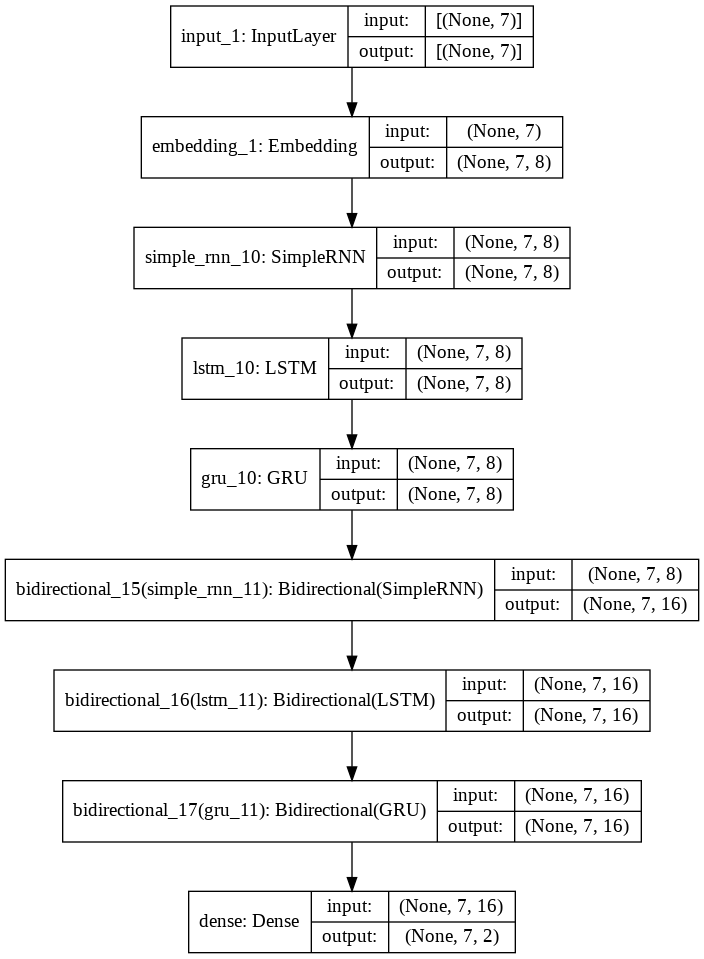

In [70]:
# 모델 생성
model = build_model(len(word_to_id), 8, 7, 2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [71]:
model.predict(train_inputs)

array([[[0.5000245 , 0.49997547],
        [0.5009043 , 0.4990956 ],
        [0.5013802 , 0.49861985],
        [0.5014072 , 0.4985928 ],
        [0.5009012 , 0.49909878],
        [0.4998655 , 0.5001345 ],
        [0.4988195 , 0.5011805 ]]], dtype=float32)